# Определение перспективного тарифа для телеком компании<a class="tocSkip">

### Цель проекта:<a class="tocSkip">

**Предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей : кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.**

### Оглавление<a class="tocSkip">

[1.Импорт данных](#step1)

[2.Предобработка данных](#step2)

[3.Анализ данных](#step3)

[4.Проверка гипотез](#step4)

- [Проверка гипотезы "средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"](#step4.1)

- [Проверка гипотезы "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"](#step4.2)

[5.Общий вывод](#step5)

<a id="step1"></a>
### 1.Открытие данных<a class="tocSkip">

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import scipy.stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv')

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
internet = pd.read_csv('/datasets/internet.csv')

In [5]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
messages = pd.read_csv('/datasets/messages.csv')

In [7]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [9]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [10]:
users = pd.read_csv('/datasets/users.csv')

In [11]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


### Вывод<a class="tocSkip">

**Файлы с данными открыты - можно переходить к предобработке данных.**

<a id="step2"></a>
### 2.Предобработка данных<a class="tocSkip">

In [12]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [13]:
calls['id'] = calls['id'].astype(int)

In [14]:
calls['call_date'] = pd.to_datetime(calls['call_date'])

In [15]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [16]:
internet['id'] = internet['id'].astype(int)

In [17]:
internet['session_date'] = pd.to_datetime(internet['session_date'])

In [18]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [19]:
messages['id'] = messages['id'].astype(int)

In [20]:
messages['message_date'] = pd.to_datetime(messages['message_date'])

In [21]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


**В таблицах "calls","messages" и "internet" для ряда знрачений не верно указан тип данных "object", произведена замена на "int64" и "datetime64". Нулевые значения продолжительности звонков, на мой взгляд не повлияют на дальнейшие расчеты, т.к. будет расчитана сумма за месяц, следовательно нет необходимости их удалять или заменять.**

In [22]:
calls['month'] = pd.to_datetime(calls['call_date']).dt.month

In [23]:
messages['month'] = pd.to_datetime(messages['message_date']).dt.month

In [24]:
internet['month'] = pd.to_datetime(internet['session_date']).dt.month
 

**Добавлены столбцы "month", необходимые для дальнейших подсчетов.**

In [25]:
calls['duration'] = calls['duration'].apply(np.ceil).replace(0, 1)

In [26]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil).replace(0, 1)

**Округлены значения времени разговоров и объема интернет-трафика.**

In [27]:
user_calls = calls.groupby(['user_id', 'month']).agg({'duration':'sum', 'id':'count'})\
.reset_index().rename(columns={'id': 'calls_count'})
                  

In [28]:
user_calls.head()

,user_id,month,duration,calls_count
0,1000,5,164.0,22
1,1000,6,187.0,43
2,1000,7,346.0,47
3,1000,8,418.0,52
4,1000,9,478.0,58


In [29]:
user_messages = messages.groupby(['user_id', 'month']).agg({'id':'count'})\
.reset_index().rename(columns={'id': 'messages_count'})

In [30]:
user_internet = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index()

In [31]:
user_messages.head()

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [32]:
user_internet.head()

,user_id,month,mb_used
0,1000,5,2257.0
1,1000,6,23262.0
2,1000,7,14017.0
3,1000,8,14072.0
4,1000,9,14583.0


**Исходные таблицы сгруппированы по пользователям и месяцам**

In [33]:
df = users.merge(user_calls, on='user_id')

In [34]:
df = df.merge(user_messages, on=['user_id', 'month'], how='outer')

In [35]:
df = df.merge(user_internet, on=['user_id', 'month'], how='outer')

In [36]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

**В таблице "tariffs" название столбца "tariff_name" изменен на "tariff", чтобы объеденить с "df".**

In [37]:
df = df.merge(tariffs, on='tariff')

**Сформирован единый датфрейм.**

In [38]:
df.head(1)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,duration,calls_count,messages_count,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,164.0,22.0,22.0,2257.0,1000,30720,3000,1950,150,1,1


In [39]:
df['minutes_overrun']  = df['duration'] - df['minutes_included']

In [40]:
df['messages_overrun'] = df['messages_count'] - df['messages_included']

In [41]:
df['mb_overrun']  = df['mb_used'] - df['mb_per_month_included'] 

**Добавлены столбцы со значениями превышения предоплаченного лимита.**

In [42]:
def get_revenue(row):
    revenue_by_min = 0
    revenue_by_messages = 0
    revenue_mb = 0
    if row['minutes_overrun'] > 0:
        revenue_by_min = row['minutes_overrun'] * row['rub_per_minute']
    if row['messages_overrun'] > 0:
        revenue_by_messages = row['messages_overrun'] * row['rub_per_message']
    if row['mb_overrun'] > 0:
        revenue_mb = (row['mb_overrun'] / 1024) * row['rub_per_gb']
   
    return revenue_by_min + revenue_by_messages + revenue_mb
    
df['revenue'] = df.apply(get_revenue, axis=1) + df['rub_monthly_fee']

**Добавден столбец - суммарный доход с каждого пользователя (абонентская плата плюс оплата услуг сверх тарифа).**

<a id="step3"></a>
## 3.Анализ данных.<a class="tocSkip">

In [43]:
df.query('tariff == "smart"')[['duration', 'messages_count', 'mb_used']].describe()

,duration,messages_count,mb_used
count,2223.000000,1916.000000,2222.000000
mean,430.609987,38.747390,16245.468047
std,193.850373,26.817396,5876.810160
min,1.000000,1.000000,1.000000
25%,292.000000,17.000000,12678.750000
50%,435.000000,34.000000,16538.000000
75%,561.000000,55.000000,20087.000000
max,1471.000000,143.000000,38627.000000


In [44]:
df.query('tariff == "smart"')[['duration', 'messages_count', 'mb_used']].var().round(2)

duration             37577.97
messages_count         719.17
mb_used           34536897.65
dtype: float64

**Исходя из выборки абонентам на тарифе "smart" в среднем требуется 430,6 мин. в месяц, дисперсия составляет 37577.97, стандартное отклонение 193,58; сообщений в среднем 38,8, дисперсия 719,17, стандартное отклонение 26,82; интернет-трафика требуется в среднем 16245.46 Мб (15,87 Гб), дисперсия 34536897.65, стандартное отклонение 5876,81.**

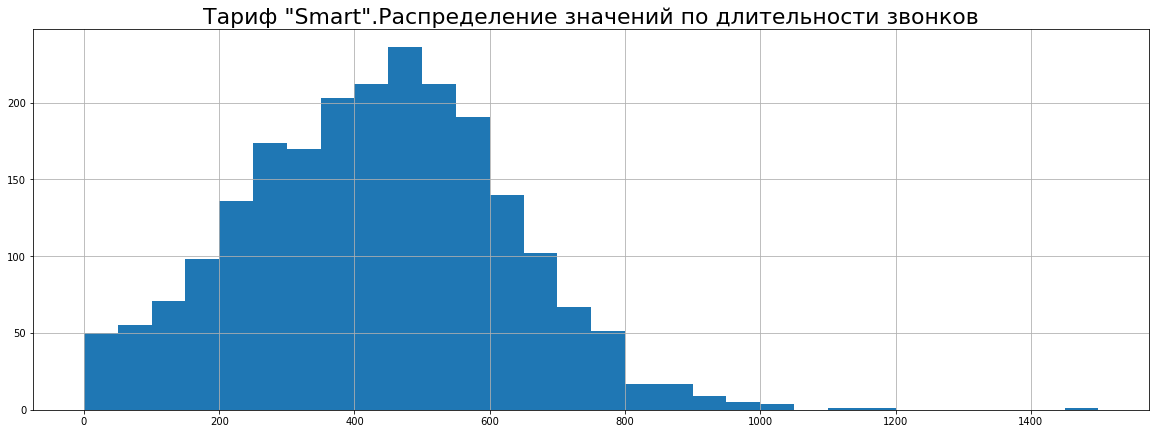

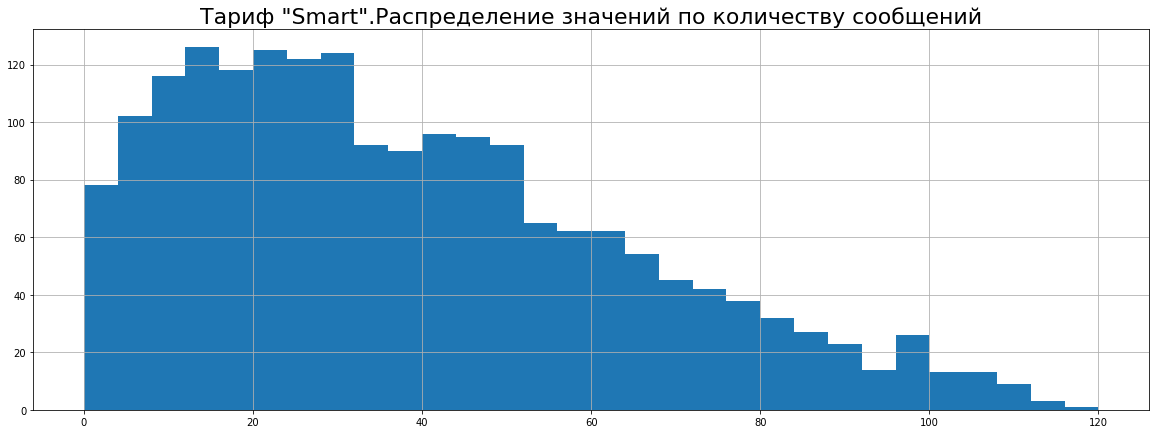

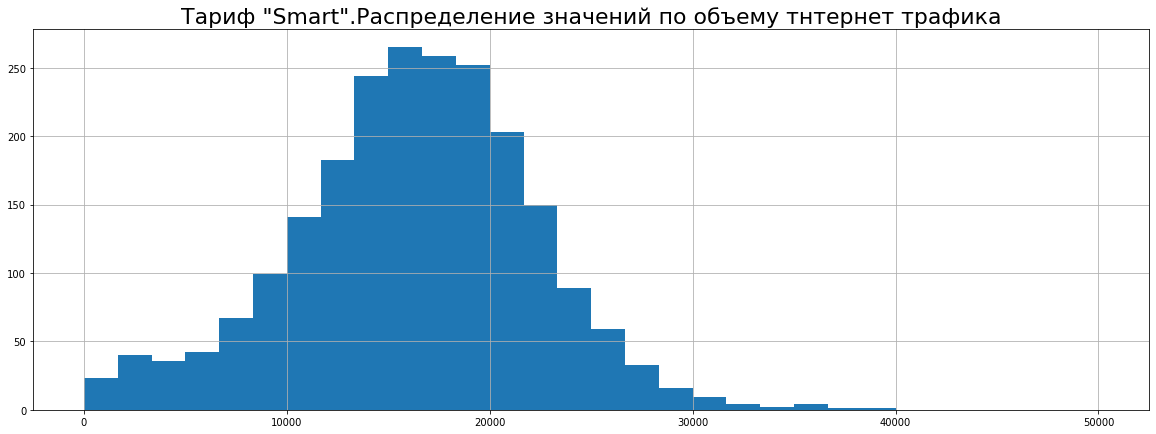

In [65]:
param_dict = {'duration':{'bins':30, 'title': 'Тариф "Smart".Распределение значений по длительности звонков',\
'max_range': 1500},\
    'messages_count': {'bins': 30,  'title': 'Тариф "Smart".Распределение значений по количеству сообщений',\
'max_range': 120},'mb_used': {'bins': 30, 'title': \
            'Тариф "Smart".Распределение значений по объему тнтернет трафика', 'max_range': 50000}}
for key, value in param_dict.items():
    df.query('tariff == "smart"')[key].hist(bins=value['bins'],figsize =(20, 7), range=(0,value['max_range']))
    plt.title(value['title'], fontsize = 22)
    plt.show()

**Гистограммы длительности звонков и интернет-трафика для пользователей тарифа "smart" близки к нормальному распределению, график по количеству сообщений имеет положительную скшенность - медианное значение больше среднего.**

In [46]:
df.query('tariff == "ultra"')[['duration', 'messages_count', 'mb_used']].describe()

,duration,messages_count,mb_used
count,951.000000,762.000000,941.000000
mean,560.113565,61.195538,19689.385760
std,314.742170,44.716597,9988.309064
min,1.000000,1.000000,1.000000
25%,318.000000,25.000000,11886.000000
50%,544.000000,52.000000,19447.000000
75%,776.500000,88.000000,26889.000000
max,1727.000000,224.000000,49793.000000


In [47]:
df.query('tariff == "ultra"')[['duration', 'messages_count', 'mb_used']].var().round(2)

duration             99062.63
messages_count        1999.57
mb_used           99766317.96
dtype: float64

**По данным выборки абонентам на тарифе "ultra" в среднем требуется 560.1 мин. в месяц, дисперсия составляет 99062.63, стандартное отклонение 314.74; сообщений в среднем  61.2, дисперсия 1999.57, стандартное отклонение 44.72; интернет-трафика требуется в среднем	19689.39 Мб (19.23 Гб), дисперсия 99766317.96, стандартное отклонение 9988.31.**

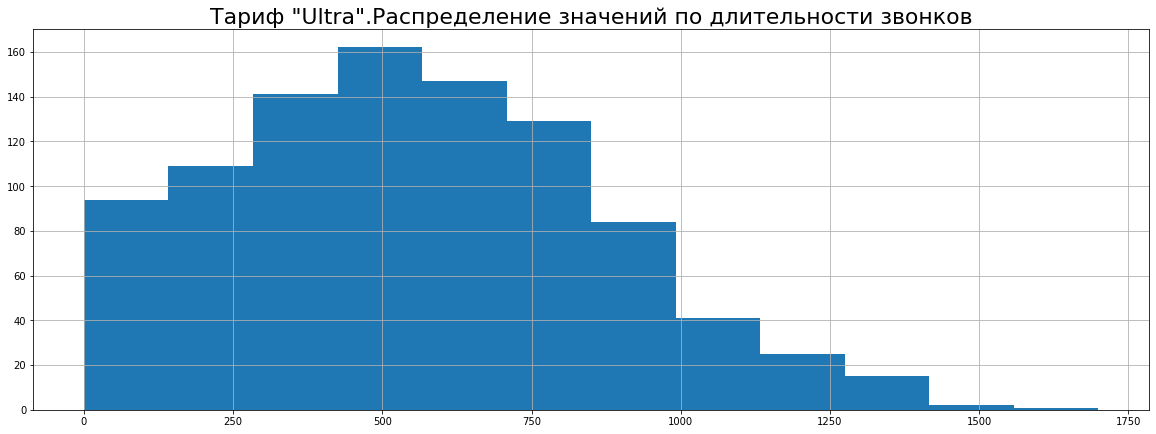

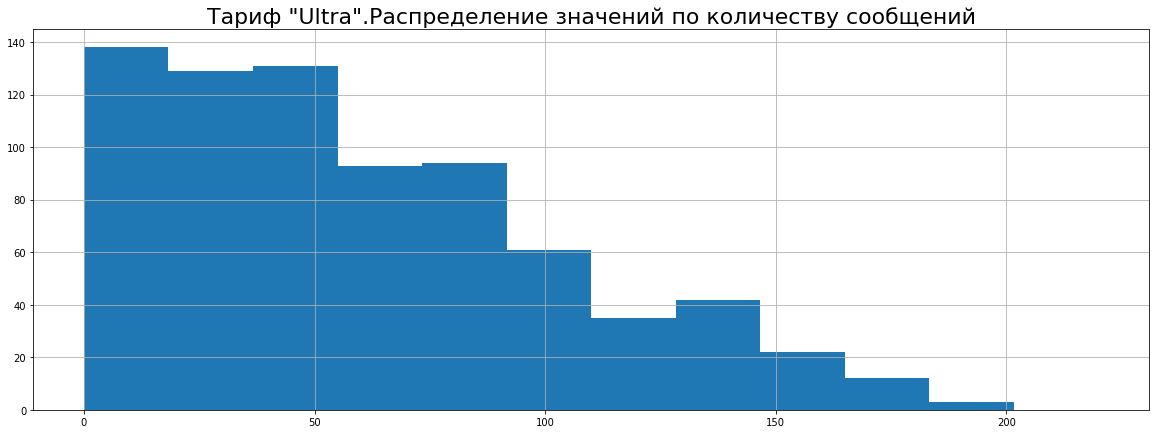

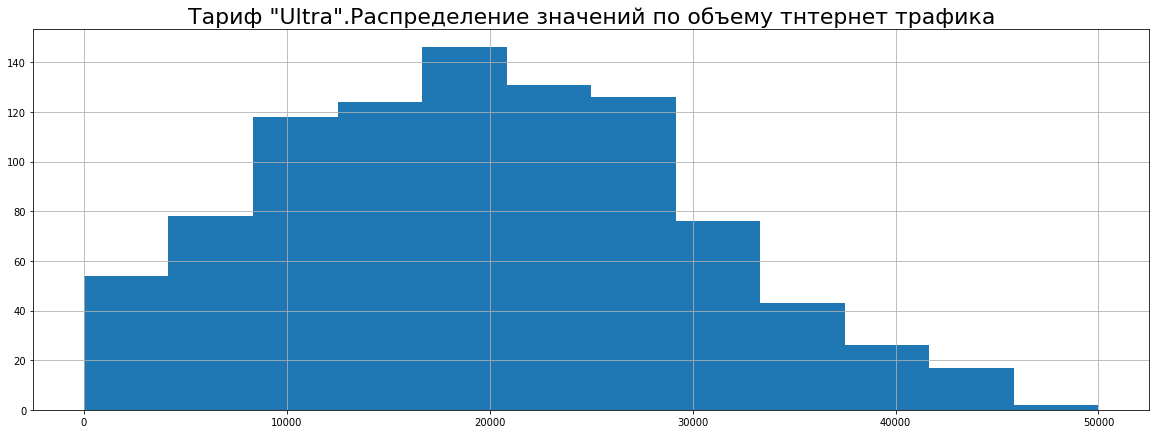

In [68]:
param_dict={'duration': {'bins': 12, 'title':'Тариф "Ultra".Распределение значений по длительности звонков',\
                         'max_range': 1700},
'messages_count': {'bins': 12,  'title': 'Тариф "Ultra".Распределение значений по количеству сообщений',\
                   'max_range': 220},
 'mb_used': {'bins': 12,  'title': 'Тариф "Ultra".Распределение значений по объему тнтернет трафика', \
             'max_range': 50000}}
for key, value in param_dict.items():
    df.query('tariff == "ultra"')[key].hist(bins=value['bins'], figsize = (20, 7), range=(0, value['max_range']))
    plt.title(value['title'], fontsize=22)
    plt.show()

**Гистограммы длительности звонков и интернет-трафика для пользователей тарифа "ultra" близки к нормальному распределению - медианы незначительно отличаются от средних, график по количеству сообщений имеет положительную скшенность - медианное значение существенно (в полтора раза) больше среднего.**

<a id="step4"></a>
## 4.Проверка гепотез<a class="tocSkip">

<a id="step4.1"></a>
- ### Проверка гипотезы "средняя выручка пользователей тарифов «Ультра» и «Смарт» различается".<a class="tocSkip">

**Принимаю в качестве нулевой гипотезы "средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются", иначе говоря "выручки равны", что соответсвует правилу: "нулевую гипотезу нужнно формулировать так, чтобы можно было использовать знак равенства". Альтернативная гипотеза - "средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются".** 

**Это гипотеза о равенстве среднего двух генеральных совокупностей, соответственно применяю метод scipy.stats.ttest_ind ().**

In [49]:
smart = df.query('tariff == "smart"')['revenue']

In [50]:
ultra = df.query('tariff == "ultra"')['revenue']

In [51]:
df.query('tariff == "smart"')['revenue'].mean().round(2)

1252.4

In [52]:
df.query('tariff == "ultra"')['revenue'].mean().round(2)

2061.53

**Средняя выручка на тарфе "Смарт" 1252,4 р., "Ультра" 2061,53 р.**

In [53]:
df.query('tariff == "smart"')['revenue'].var()

637476.6419242031

In [54]:
df.query('tariff == "ultra"')['revenue'].var()

129301.73016137585

**Дисперсии выборок не равны, значит нужно указать параметр equal_var = False.**

In [55]:
alpha = .05

In [56]:
results = st.ttest_ind(smart, ultra, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.359406166646201e-276
Отвергаем нулевую гипотезу


**Исходя из этого, могу сказать, что данные выборки не противоречат гипотезе "средняя выручка пользователей тарифов «Ультра» и «Смарт» различается".**

<a id="step4.2"></a>
- ### Проверка гипотезы "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов".<a class="tocSkip">

**Принимаю в качестве нулевой гипотезы "средняя выручка пользователей из Москвы  не отличается от выручки пользователей из других регионов", иначе говоря "выручки равны", что соответсвует правилу: "нулевую гипотезу нужнно формулировать так, чтобы можно было использовать знак равенства". Альтернативная гипотеза - "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов".**

**Данная так же является гипотезой о равенстве среднего двух генеральных совокупностей, соответственно применяю метод scipy.stats.ttest_ind ().**

In [57]:
moscow = df.query('city == "Москва"')['revenue']

In [58]:
moscow.mean().round(2)

1517.04

In [59]:
region = df.query('city != "Москва"')['revenue']

In [60]:
region.mean().round(2)

1489.55

**Средняя выручка пользователей из Москвы 1517.04 р., из других регионов - 1489,55**

In [61]:
df.query('city == "Москва"')['revenue'].var()

549697.5230807818

In [62]:
df.query('city != "Москва"')['revenue'].var()

639968.0170283015

**Дисперсии выборок не равны, значит нужно указать параметр equal_var = False.**

In [63]:
alpha = .05

In [64]:
results = st.ttest_ind(moscow, region, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.41795844601113885
Не получилось отвергнуть нулевую гипотезу


**Соответственно, гипотезу "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов" считаю крайне маловероятной.**

<a id="step5"></a>
## 5.Общий вывод<a class="tocSkip">

**В ходе  выполненяя проекта изучена  выборка из данных о пользователях компании-операторатора сотовой связи. Анализ данных выбори показывает, что абоненты, пользующиеся тарфом "Смарт" в среднем не превышают предоплаченный лимит, за исключением интернет-трафика, а пользователи тарифа "Ультра" существенно недорасходуют оплаченные услуги. При этом пользователи "Смарт" в среднем платят 1252.4 р.в мес. ( +127,71% к абонентской плате), а абоненты на тарифе "Ультра" - 2061,53 (+5,72%). Таким образом, думаю можно сделать вывод, что оба тарифа выгодны, - "Ультра" приносит больший доход с каждого абонента, но, вероятно, "Смарт" - более массовый благодаря кажущейся доступности.**